In [39]:
import json
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [40]:
# 000000001000.png
# 000000002473.png'
# 000000002299.png
# 000000000872.png
# 000000013291.png

In [41]:
im_name = f'000000005001.png'
image_dir = f'val2017'
panopatic_image_dir = f'panoptic_val2017'
json_file = 'panoptic_val2017.json'

In [42]:
with open(json_file, 'r') as f:
    data = json.load(f)

In [43]:
image_path = os.path.join(panopatic_image_dir, im_name)
base_name, ext = os.path.splitext(image_path)

panoptic_val2017\000000005001
.png


In [44]:
im = cv2.imread(image_path)
im = np.array(im)
height, width,c = im.shape

In [45]:
unique_colors = np.unique(im.reshape(-1, 3), axis=0)
zeros = np.zeros((len(unique_colors), height, width), dtype=np.uint8)

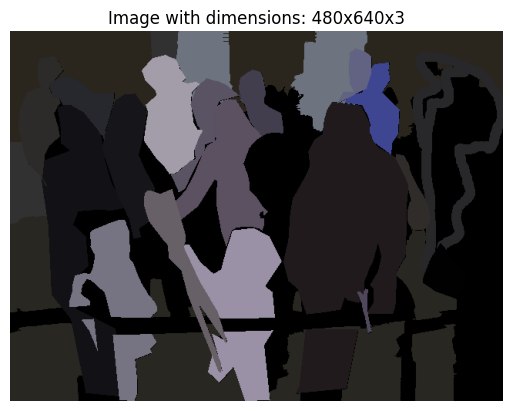

In [46]:
plt.imshow(im)
plt.title(f"Image with dimensions: {height}x{width}x{c}")
plt.axis('off')
plt.show()

In [47]:
for i in range(unique_colors.shape[0]):
    mask = (im == unique_colors[i]).all(axis=2)
    mask_uint8 = (mask * 255).astype(np.uint8)
    zeros[i]= mask_uint8

In [48]:
human_bbox = []
no_human_bbox = []
obj_bbox = []

for annotation in data['annotations']:
    if annotation['file_name'] == im_name:
        for segment in annotation['segments_info']:
            if segment['category_id'] == 1:
                human_bbox.append(segment['bbox'])
            elif 1 < segment['category_id'] <= 90:
                obj_bbox.append(segment['bbox'])
            elif segment['category_id'] >= 92:
                no_human_bbox.append(segment['bbox'])

print("Human bounding boxes:", human_bbox)
print("Non-human bounding boxes:", no_human_bbox)
print("Object bounding boxes:", obj_bbox)


Human bounding boxes: [[297, 50, 58, 87], [51, 59, 84, 83], [355, 92, 162, 378], [226, 256, 127, 224], [425, 23, 44, 71], [171, 31, 79, 155], [209, 61, 89, 148], [435, 41, 71, 119], [77, 245, 114, 235], [11, 33, 58, 168], [119, 81, 69, 189], [41, 96, 107, 378], [215, 88, 120, 191], [523, 26, 117, 286]]
Non-human bounding boxes: [[209, 0, 255, 131], [0, 0, 640, 144], [0, 240, 580, 240], [0, 0, 219, 250]]
Object bounding boxes: [[500, 159, 46, 99], [536, 275, 59, 72], [174, 205, 107, 238], [451, 334, 19, 58]]


In [49]:
def draw_bounding_boxes(image, bboxes, color, thickness=2):
    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
    return image

In [50]:
if im_name.endswith(".png"):
    im_name = os.path.splitext(im_name)[0] + ".jpg"

In [51]:
image_path = os.path.join(image_dir, im_name)
image_show = cv2.imread(image_path)
if image_show is None:
    raise FileNotFoundError(f"Failed to load image: {image_path}")
image_with_human_boxes = image_show.copy()
image_with_no_human_boxes = image_show.copy()

In [52]:
image_with_human_boxes = draw_bounding_boxes(image_with_human_boxes, human_bbox, color=(0, 255, 0))
image_with_object_boxes = draw_bounding_boxes(image_with_human_boxes, obj_bbox, color=(255, 0, 0))
image_with_no_human_boxes = draw_bounding_boxes(image_with_no_human_boxes, no_human_bbox, color=(0, 0, 255))

In [58]:
cv2.imshow('Image with Human Bounding Boxes', image_with_human_boxes)
cv2.imshow('Image with No-Human Bounding Boxes', image_with_no_human_boxes)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [54]:
def check_region(zeros_slice, bbox):
    x, y, w, h = bbox
    region = zeros_slice[y:y+h, x:x+w]
    mask_zeros = zeros_slice == 255
    mask_region = region == 255
    return np.sum(mask_zeros) == np.sum(mask_region)


def check_sizes(no_h_sizes, h_sizes, no_h_memory, h_memory, mask_layer_i):
    # [obj1_size, obj2_size, ....]
    filtered_no_h_iou = [ np.sum(mask_layer_i == 255)/ no_h_sizes[j] for j in range(len(no_h_memory)) if no_h_memory[j]]
    print('filtered_no_h_iou',filtered_no_h_iou)
    filtered_h_iou = [ np.sum(mask_layer_i == 255)/ h_sizes[j] for j in range(len(h_memory)) if h_memory[j]]
    print('filtered_h_iou',filtered_h_iou)

    max_no_h_iou = 0
    max_h_iou = 0

    for no_h_size in filtered_no_h_iou:
        if no_h_size>max_no_h_iou:
            max_no_h_iou = no_h_size
    for h_size in filtered_h_iou:
        if h_size>max_h_iou:
            max_h_iou = h_size
    print(max_no_h_iou, max_h_iou)

    if max_no_h_iou > max_h_iou:
        return True
    else:
        return False

for i in range(unique_colors.shape[0]):
    h_sizes = np.array([bbox[3] * bbox[2] for bbox in human_bbox])
    no_h_size = np.array([bbox[3] * bbox[2] for bbox in no_human_bbox])
    obj_size = np.array([bbox[3] * bbox[2] for bbox in obj_bbox])
    h_memory = np.array([bool(check_region(zeros[i], bbox)) for bbox in human_bbox])
    no_h_memory = np.array([bool(check_region(zeros[i], bbox)) for bbox in no_human_bbox])
    ojb_memory = np.array([bool(check_region(zeros[i], bbox)) for bbox in obj_bbox])

    if not np.any(h_memory):
        zeros[i, :] = np.zeros_like(zeros[i, :])

    elif np.any(h_memory) and np.any(no_h_memory) and check_sizes(no_h_size, h_sizes, no_h_memory, h_memory, zeros[i]):
        zeros[i, :] = np.zeros_like(zeros[i, :])

    elif np.any(h_memory) and np.any(ojb_memory) and check_sizes(obj_size, h_sizes, ojb_memory, h_memory, zeros[i]):
        zeros[i, :] = np.zeros_like(zeros[i, :])



filtered_no_h_iou [np.float64(0.03232421875), np.float64(0.05441095890410959)]
filtered_h_iou [np.float64(0.4272805507745267)]
0.05441095890410959 0.4272805507745267
filtered_no_h_iou [np.float64(0.09326027397260274)]
filtered_h_iou [np.float64(0.5240147783251231)]
0.09326027397260274 0.5240147783251231
filtered_no_h_iou [np.float64(0.029752604166666665)]
filtered_h_iou [np.float64(0.5434007134363853)]
0.029752604166666665 0.5434007134363853
filtered_no_h_iou [np.float64(0.002672413793103448)]
filtered_h_iou [np.float64(0.006074857926709779)]
0.002672413793103448 0.006074857926709779
filtered_no_h_iou [np.float64(0.33756805807622503)]
filtered_h_iou [np.float64(0.006074857926709779)]
0.33756805807622503 0.006074857926709779
filtered_no_h_iou [np.float64(0.01648220486111111)]
filtered_h_iou [np.float64(0.48623559539052497)]
0.01648220486111111 0.48623559539052497
filtered_no_h_iou [np.float64(0.07597701149425287)]
filtered_h_iou [np.float64(0.39477416946621874)]
0.07597701149425287 0.39

In [55]:
overlay_sum = np.sum(zeros, axis=0)
cv2.imwrite(f"final.png", overlay_sum)


True

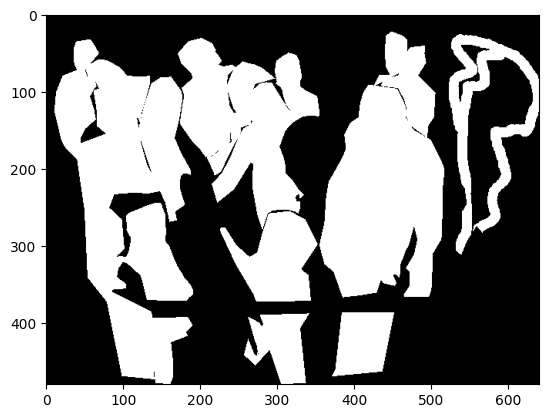

In [56]:
plt.imshow(overlay_sum, cmap='gray')